# **Classify Waste Products Using Transfer Learning**


### Importing Required Libraries


In [1]:
import numpy as np
import os
# import random, shutil
import glob


from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread

# from os import makedirs,listdir
# from shutil import copyfile
# from random import seed
# from random import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')


## Create a model for distinguishing recyclable and organic waste images
(1 = recyclable, 0 = organic)

### Importing Data

In [2]:
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist() 
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [00:00<00:00, 3678.68file/s]

Finished extracting file
Finished extracting file


### Define configuration options

It's time to define some model configuration options.

*   **batch size** is set to 32.
*   The **number of classes** is 2.
*   You will use 20% of the data for **validation** purposes.
*   You have two **labels** in your dataset: organic (O), recyclable (R).


In [3]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

### Loading Images using ImageGeneratorClass

The folder structure will be as follows:

```python
o-vs-r-split/
└── train
    ├── O
    └── R
└── test
    ├── O
    └── R
```




In [4]:
# Create ImageDataGenerators for training and validation and testing
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

Found 800 images belonging to 2 classes.


In [6]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 200 images belonging to 2 classes.


In [7]:
# Create a `test_generator` using the `test_datagen` object
test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    target_size=(img_rows, img_cols)
)

Found 200 images belonging to 2 classes.


## **Assess Data Generators**

View sample images from both classess

Recall directory structure:
```python
o-vs-r-split/
└── train
    ├── O
    └── R
└── test
    ├── O
    └── R
```

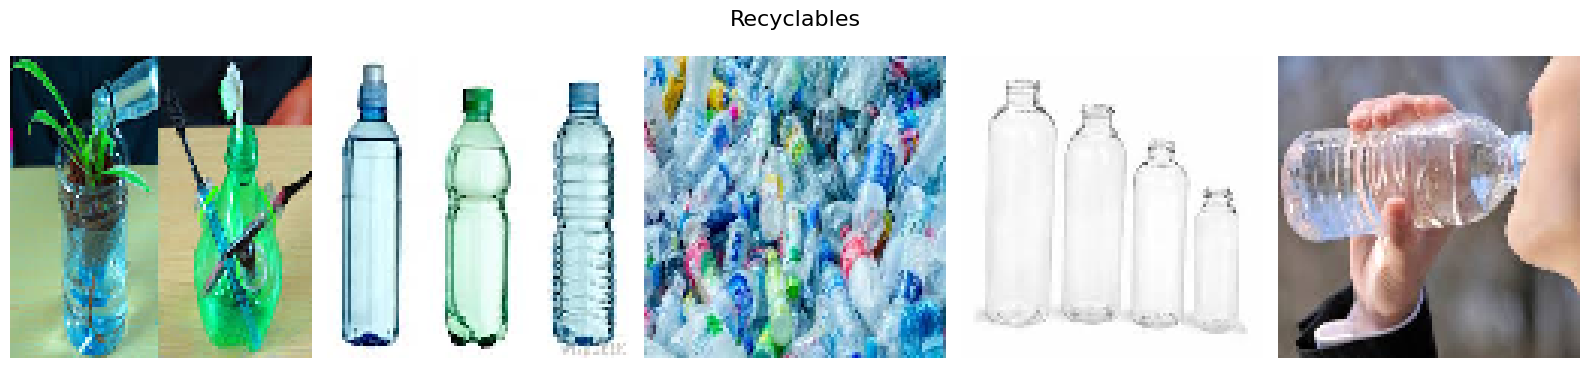

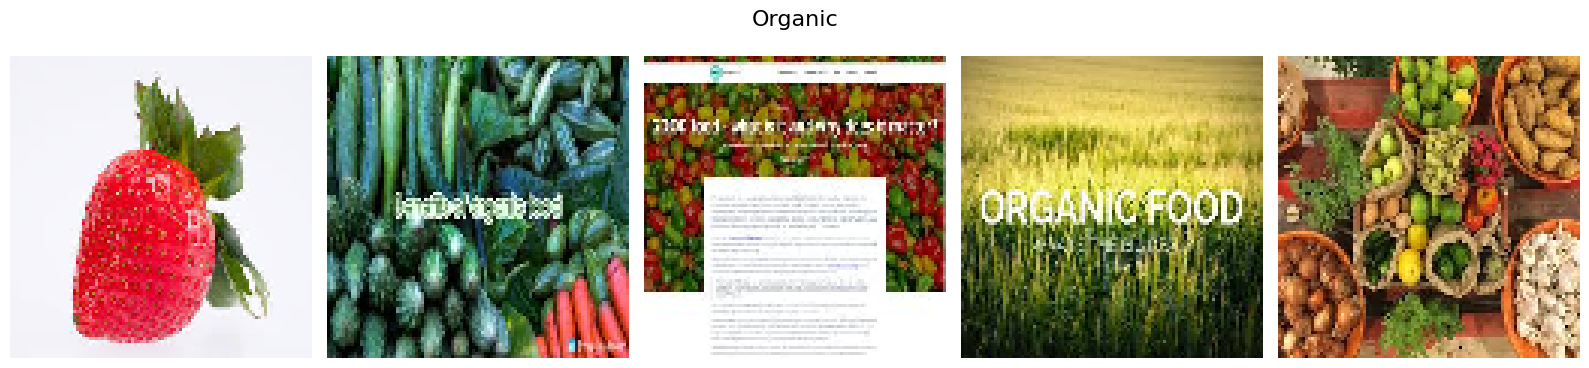

In [8]:
def plot_images_from_datagenloader(directory, num_images, title):
    train_files = glob.glob(f'./o-vs-r-split/train/{directory}/*')
    #img_count = range(num_images)
    train_files = train_files[:num_images]
    train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
    train_imgs = np.array(train_imgs)

    fig, axes = plt.subplots(1,num_images, figsize=(16, 6))
    fig.suptitle(title, fontsize=16, y=0.8)
    for i in range(num_images):
        axes[i].imshow(train_imgs[i].astype('uint8'))
        axes[i].axis('off')
    plt.tight_layout()
    plt.show


IMG_DIM = (100, 100)

# Plot recyclables
plot_images_from_datagenloader("R", 5, "Recyclables")

# Plot organic material
plot_images_from_datagenloader("O", 5, "Organic")

View samples of train_generator's augmented images:

Labels: ['O', 'O', 'O', 'O', 'O']


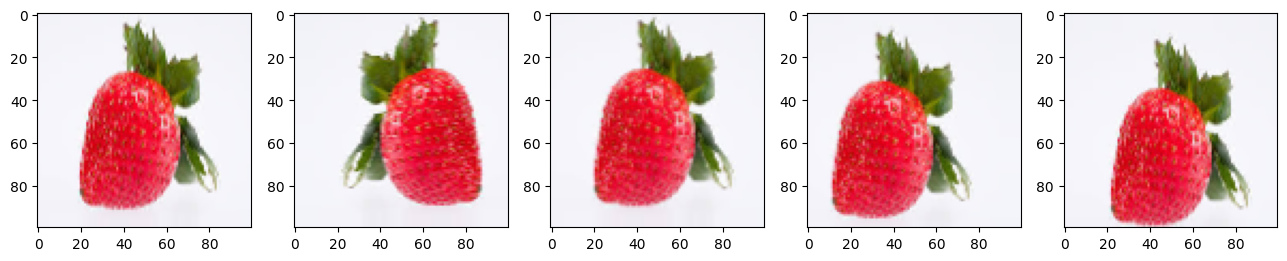

In [9]:
from pathlib import Path

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]


## **Fine Tune Pre-trained VGG-16 Model**


In [10]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=input_shape)
vgg.trainable = False


Flatten final layer of a vgg model (i.e. maxpool layer) and assign it to the model `output` to make a dense layer, then use a Model object `basemodel` to group the layers into an object for training and inference .

inputs: `vgg.input`

outputs: `tf.keras.layers.Flatten()(output)`


Freeze all layers

Freeze all but final two layers of basemodel.


In [11]:
display([layer.name for layer in vgg.layers])

['input_layer',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool']

In [12]:
set_trainable = False

for layer in vgg.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in vgg.layers:
    print(f"{layer.name}: {layer.trainable}")

input_layer: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True


In [13]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Create sequential model to add VGG16 to fully connected layers and output layer

In [14]:
model = Sequential()

model.add(vgg)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 6,817,793 (26.01 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

Confirm correct layers are frozen

In [16]:
for layer in model.layers:
    print(f"{layer.name}: {layer.trainable}")

vgg16: False
flatten: True
dense: True
dropout: True
dense_1: True
dropout_1: True
dense_2: True


## **Compile the model**

In [17]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

In [18]:
from tensorflow.keras.callbacks import LearningRateScheduler


checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

## **Fit and train the model**

In [19]:
fine_tune_model = model.fit(train_generator,
                            steps_per_epoch=5,
                            epochs=10,
                            callbacks = callbacks_list_,
                            validation_data=val_generator,
                            validation_steps=val_generator.samples // batch_size,
                            verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.4836 - loss: 0.8454lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4905 - loss: 0.8385 - val_accuracy: 0.6510 - val_loss: 0.6018 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.6705 - loss: 0.5872lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 999ms/step - accuracy: 0.6796 - loss: 0.5802 - val_accuracy: 0.8125 - val_loss: 0.4500 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.7088 - loss: 0.5011lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 974ms/step - accuracy: 0.7177 - loss: 0.4958 - val_accuracy: 0.7969 - val_loss: 0.4209 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8567 - loss: 0.3716lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 977ms/step - accuracy: 0.8514 - loss: 0.3789 - val_accuracy: 0.8021 - val_loss: 0.4038 - learning_rate: 7.4082

### Plot loss curves for training and validation sets

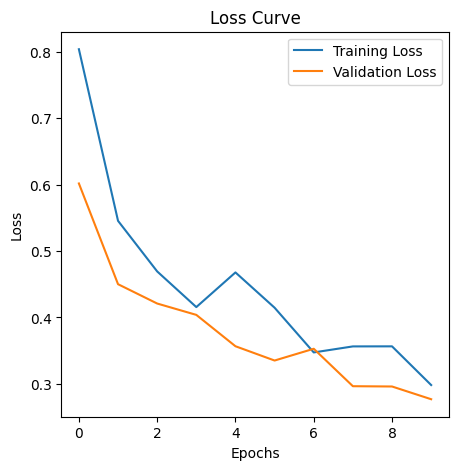

In [20]:
import matplotlib.pyplot as plt

history = fine_tune_model

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Plot accuracy curves for training and validation sets

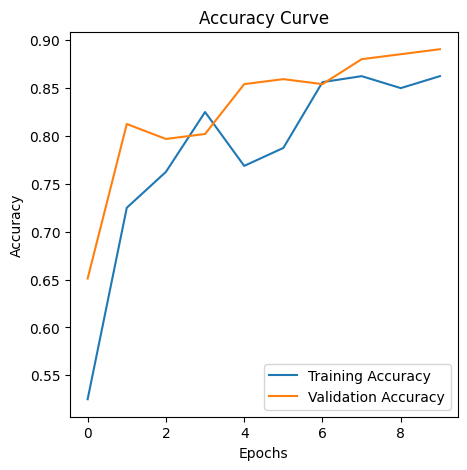

In [21]:
import matplotlib.pyplot as plt

history = fine_tune_model
## Task 6: Plot accuracy curves for training and validation sets
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [22]:
from pathlib import Path

fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for model
predictions_fine_tune_model = model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))


Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.80      0.80      0.80        50
           R       0.80      0.80      0.80        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



Create function to visualize prediction results

In [23]:
def plot_image_with_prediction(images, labels, predicted, num_cols, num_rows):
    from random import sample

    rand_list = sample(range(len(images)), num_cols*num_rows)
    rand_images = images[rand_list]
    rand_labels = [labels[i] for i in rand_list]
    rand_predicts = [predicted[i] for i in rand_list]

    num_images = len(rand_images)

    fig, axs = plt.subplots(num_rows, num_cols * 2, figsize=(20, num_rows))

    for idx in range(num_images):
        row = idx // num_cols
        col = (idx % num_cols) * 2
        
        # Plot the image
        axs[row, col].imshow(rand_images[idx].astype('uint8'))
        axs[row, col].axis('off')
        # Display actual and predicted labels
        axs[row, col + 1].text(0.5, 0.5, f"Actual: {rand_labels[idx]}\nPredicted: {rand_predicts[idx]}",
                            horizontalalignment='center', verticalalignment='center', fontsize=12)
        axs[row, col + 1].axis('off')

    # Turn off any remaining empty subplots
    for idx in range(num_images, num_rows * num_cols):
        row = idx // num_cols
        col = (idx % num_cols) * 2
        axs[row, col].axis('off')
        axs[row, col + 1].axis('off')

    plt.tight_layout()
    plt.show()

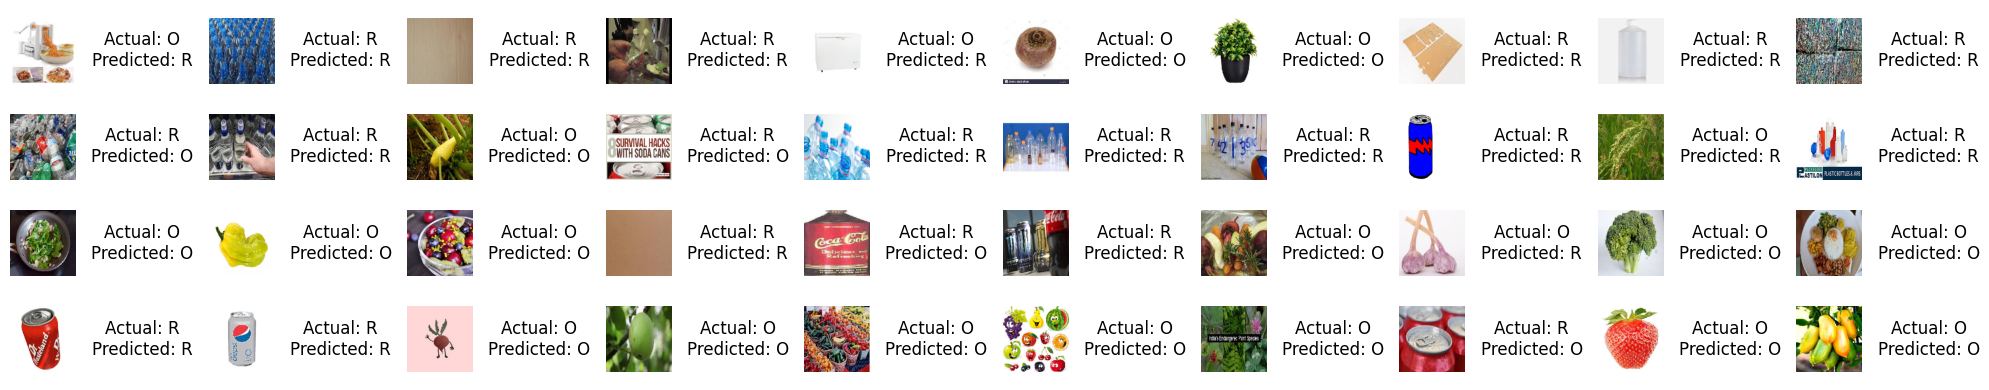

In [24]:
plot_image_with_prediction(test_imgs, test_labels, predictions_fine_tune_model, 10, 4)